In [1]:
from spkit import bkt
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 0

In [211]:
%aimport spkit.bkt

### Reading KDD train file
Drop rows with null in any of the important columns

In [3]:
%%time
df_all = pd.read_csv('algebra_2005_2006_test.txt', delimiter='\t')
print(df_all.shape)

(3967, 19)
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 104 ms


In [4]:
df = df_all[['Anon Student Id', 'Correct First Attempt', 'Problem Hierarchy', 'Problem Name', 'Problem View', 'Step Name', 'KC(Default)']]

In [5]:
df = df.dropna()

In [6]:
df.shape

(607025, 7)

### Preprocessing
Transform dataframe in a format understood by the BKT module

In [163]:
skipped = []
def get_kcs(row):
    text = row['KC(Default)'].replace(',','')
    kc_list = text.split('~~')
    kc = []
    for item in kc_list:
        # Option 1: with SkillRule prefix
        found_opt1 = re.findall(r'^\[SkillRule: ([\w ]+[ ,/?-]*[\w ]*);.*', item, flags=re.M)
        # Option 2: regular words (hyphenized or spaced)
        found_opt2 = re.findall(r'^([\w -]+).*', item, flags=re.M)
        # Option 3: get what couldn't be extracted from previous patterns
        found_opt3 = re.findall(r'^\[SkillRule: (.*);.*', item, flags=re.M)
        if found_opt1:
            kc.append(found_opt1[0])
        elif found_opt2:
            kc.append(found_opt2[0])
        elif found_opt3:
            kc.append(found_opt3[0])
        else:
            skipped.append(item)
    return kc

def get_steps(row):
    step = row['Problem Hierarchy'] + '_' + row["Problem Name"] + '_' + row['Step Name']
    return step

Separate KCs in a list and create an identifier name for the step

In [164]:
%%time
df['KC'] = df.apply(get_kcs, axis=1)
df['step'] = df.apply(get_steps, axis=1)

CPU times: user 35.5 s, sys: 124 ms, total: 35.7 s
Wall time: 35.7 s


In [165]:
%%time
kcs = []
for row in df['KC'].iteritems():
    kcs.extend(row[1])
kcs = list(set(kcs))
steps = df['step'].unique().tolist()

def create_data(row):
    question_id = steps.index(row['step'])
    return question_id

df['question_id'] = df.apply(create_data, axis=1)

CPU times: user 9min 31s, sys: 500 ms, total: 9min 32s
Wall time: 9min 32s


In [167]:
len(kcs)

110

Construct Q-Matrix

In [171]:
%%time
q_matrix = np.zeros((len(steps), len(kcs)))

for idx, item in df.iterrows():
    for kc in item['KC']:
        kc_col = kcs.index(kc)
        q_matrix[item['question_id'], kc_col] = 1
    
print(q_matrix.shape)

(176630, 110)
CPU times: user 1min 30s, sys: 124 ms, total: 1min 31s
Wall time: 1min 31s


Save data

In [172]:
import pickle
with open('kdd_2005_2005_df.pkl', 'wb') as pklfile:
    pickle.dump(df, pklfile)
with open('kdd_2005_2005_q_matrix.pkl', 'wb') as pklfile:
    pickle.dump(q_matrix, pklfile)

### Fitting data

In [173]:
%%time
# Data matrix
data = df[['Correct First Attempt', 'Anon Student Id', 'question_id']].values.tolist()

# Instantiate model
model = bkt.BKT()
model.fit(data, q_matrix)

CPU times: user 7.04 s, sys: 40 ms, total: 7.08 s
Wall time: 10 s


In [174]:
students = df['Anon Student Id'].unique().tolist()
len(students)

574

In [420]:
with open('kdd_2005_2005_students.pkl', 'wb') as pklfile:
    pickle.dump(students, pklfile)
with open('kdd_2005_2005_model.pkl', 'wb') as pklfile:
    pickle.dump(model, pklfile)

In [283]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
outcome_all = []
predicted_proba = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    predicted = model.predict_proba(data_student, q_matrix)
    predicted_proba += predicted[:,1].tolist()
    s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
                     "LL": model.loglikelihood.sum(),
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/metrics/ranking.py:648: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


CPU times: user 42.3 s, sys: 108 ms, total: 42.4 s
Wall time: 42.4 s


In [284]:
score = pd.DataFrame.from_dict(score_df)

In [285]:
with open('kdd_2005_2005_score.pkl', 'wb') as pklfile:
    pickle.dump(score, pklfile)

In [286]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [287]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.41
RMSE médio: 0.43 +- 0.05


In [288]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [289]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.75
Acc médio: 0.69 +- 0.12


In [355]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.73


In [357]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.73
AUC médio: 0.69 +- 0.09


Recalculating accuracy after adjusting cutoff point with Youden's Index

In [356]:
estimated_outcome = np.where(np.asarray(predicted_proba) > opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6976598986862156

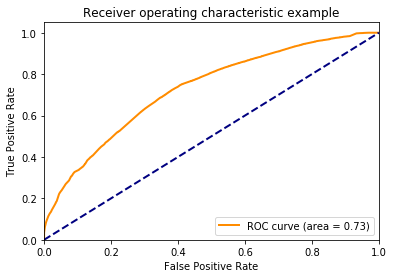

In [358]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Comparing accuracy to random baseline

In [419]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6309904863885343

In [303]:
score.sort_values(["AUC"], ascending=False)

,AIC,AUC,Acc,BIC,LL,RMSE,correct_outcome,incorrect_outcome,n questions,student
312,911.648029,0.890351,0.677419,1542.602399,-15.824014,0.419527,19,12,31,h4N48ldyLn
570,1056.276865,0.875297,0.865613,2610.968240,-88.138432,0.321204,227,26,253,w0FMzJORlK
520,913.672191,0.857143,0.176471,1280.286062,-16.836095,0.625189,14,3,17,k71nQKqIB3
411,1594.558794,0.856010,0.796006,3597.662264,-357.279397,0.406271,302,399,701,b4WRCgbjkN
370,966.691522,0.837868,0.552239,1936.756274,-43.345761,0.486018,49,18,67,h31E235Th5
476,1292.413011,0.834890,0.807393,3158.991248,-206.206505,0.354405,467,47,514,Q0Fp6Da7G1
63,891.251929,0.833333,0.428571,867.452395,-5.625964,0.549957,4,3,7,LIXD5c0lE5
54,5023.031285,0.827732,0.751172,7749.099494,-2071.515642,0.434709,1116,2509,3625,LM96hW22T2
358,1225.640398,0.819862,0.799499,2980.783421,-172.820199,0.370635,339,60,399,Qb2LYvN3zF
334,963.863349,0.817628,0.721519,2006.420404,-41.931675,0.419353,39,40,79,7H6yD0xNNn


In [304]:
score.sort_values(["Acc"], ascending=False)

,AIC,AUC,Acc,BIC,LL,RMSE,correct_outcome,incorrect_outcome,n questions,student
193,2461.291993,0.718024,0.865932,4963.203407,-790.645997,0.327767,1956,222,2178,hwF4tyWU50
570,1056.276865,0.875297,0.865613,2610.968240,-88.138432,0.321204,227,26,253,w0FMzJORlK
41,2497.059757,0.715512,0.854665,4989.785033,-808.529878,0.338710,1883,250,2133,mNzo8mGzu9
92,1877.660522,0.710554,0.849926,4167.813227,-498.830261,0.334378,1217,129,1346,5x5fHvFFLv
362,1732.633721,0.721863,0.848972,3941.517633,-426.316861,0.338708,995,124,1119,YvD7H8XduF
98,2619.933409,0.712787,0.847997,5145.059863,-869.966705,0.339027,2013,283,2296,56dTCKdr74
128,2544.246426,0.717096,0.840211,5026.745963,-832.123213,0.350932,1785,299,2084,66Ak255E3j
477,1590.380943,0.752549,0.836226,3714.060841,-355.190471,0.342823,822,100,922,rE6U5574qn
42,3206.678790,0.708263,0.832236,5832.282069,-1163.339395,0.353340,2475,410,2885,z9svx3mA4s
163,2602.871613,0.709198,0.830198,5094.150539,-861.435807,0.354276,1823,303,2126,apCLF0uF21
